<a href="https://colab.research.google.com/github/Sabavat-Jayanth-Naik/Final-Year-Project-Cyberbullying-detection/blob/main/CYBER_BULLYING_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-learn
!pip install --upgrade scikit-learn

!pip install emoji
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle
import time


In [4]:
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DataSets/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47693 entries, 0 to 47692
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47693 non-null  object
 1   cyberbullying_type  47693 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
df.dtypes

tweet_text            object
cyberbullying_type    object
dtype: object

In [7]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [8]:
if df['cyberbullying_type'].isna().any():
    df = df.dropna(subset=['cyberbullying_type'])


In [9]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [10]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'bully_type'})

In [11]:
df.duplicated().sum()

46

In [12]:
df = df[~df.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47647 entries, 0 to 47692
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        47647 non-null  object
 1   bully_type  47647 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [13]:
# Now we want to check if the data class is balance
df['bully_type'].value_counts()

bully_type
religion               7997
age                    7990
ethnicity              7959
gender                 7945
not_cyberbullying      7935
other_cyberbullying    7821
Name: count, dtype: int64

In [14]:
import re, string
import emoji #!pip install emoji
import nltk #!pip install nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
# Regular Expression pattern of text cleaning pattern
# This REGEX pattern remove any @tagname from tweet, remove #hashtag !@#$%^&*: etc., remove website name like https:///www.fb.com
# But will remain all the A-Z a-z 0-9 character
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# pip install wordcloud
# import word cloud to produce wordcloud on cleaned twitter text for data exploration
from wordcloud import STOPWORDS
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's'])

# Function To preprocess the twitter text

# Lowercase all text
def lower(text):
    return text.lower()

# To clean the tweet with REGEX above
def clean_tweet_re(text):
    return re.sub(TEXT_CLEANING_RE, ' ', text)

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [16]:
# Create a copy of df for visualization
df_visual = df.copy()

df_visual['text'] = df_visual['text'].astype(str).apply(lower)
df_visual['text'] = df_visual['text'].apply(clean_tweet_re)
df_visual['text'] = df_visual['text'].apply(remove_stopwords)


# Color Class for python printing, Making print more easy to read
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Comparing Original Tweet Text vs cleaned Tweet Text, Original black bold color vs Clean green bold color
for i in range(0, 10):
    original_text = df_visual['text'].head(10)[i]
    cleaned_text = df_visual['text'].head(10)[i]
    comparision = f'{color.BOLD} {i}) {original_text} ==>> {color.GREEN} {color.BOLD} {cleaned_text} {color.END}\n'
    print(comparision)

 0) words katandandre food crapilicious ==>>   words katandandre food crapilicious 

 1) eek stand split keyboards doesn work well mmos ==>>   eek stand split keyboards doesn work well mmos 

 2) spacekatgal rather funny us completely different yet complement skill sets well ==>>   spacekatgal rather funny us completely different yet complement skill sets well 

 3) old oil cliche us pays every drop oil open market every country ==>>   old oil cliche us pays every drop oil open market every country 

 4) aussietv white theblock imacelebrityau today sunrise studio10 neighbours wonderlandten etc ==>>   aussietv white theblock imacelebrityau today sunrise studio10 neighbours wonderlandten etc 

 5) talking 2 employees heard lot internal politics re gg enough make stay ==>>   talking 2 employees heard lot internal politics re gg enough make stay 

 6) meh p thanks heads concerned another angry dude twitter ==>>   meh p thanks heads concerned another angry dude twitter 

 7) isis account pr

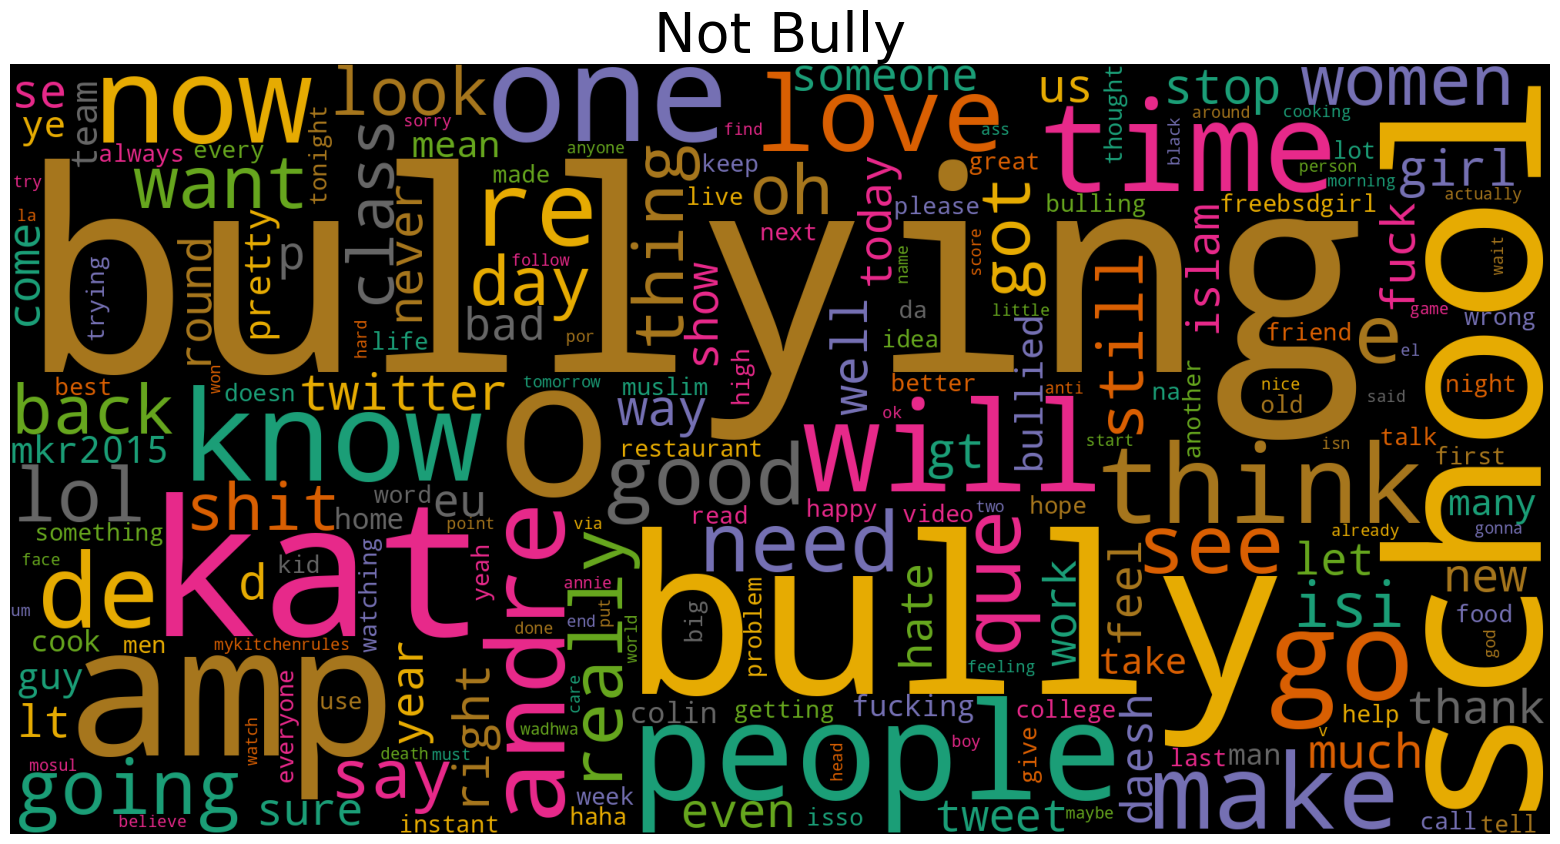

In [17]:
# Import word cloud to visualize highest count word with cloud display effect
from wordcloud import WordCloud

plt.figure(figsize=(20, 10)) #Setting figure size to better width
subset_notbully = df_visual[df_visual['bully_type'] == 'not_cyberbullying']
text_notbully = subset_notbully.text.values
cloud_notbully = WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_notbully))

plt.axis('off')
plt.title("Not Bully", fontsize=40)
plt.imshow(cloud_notbully)

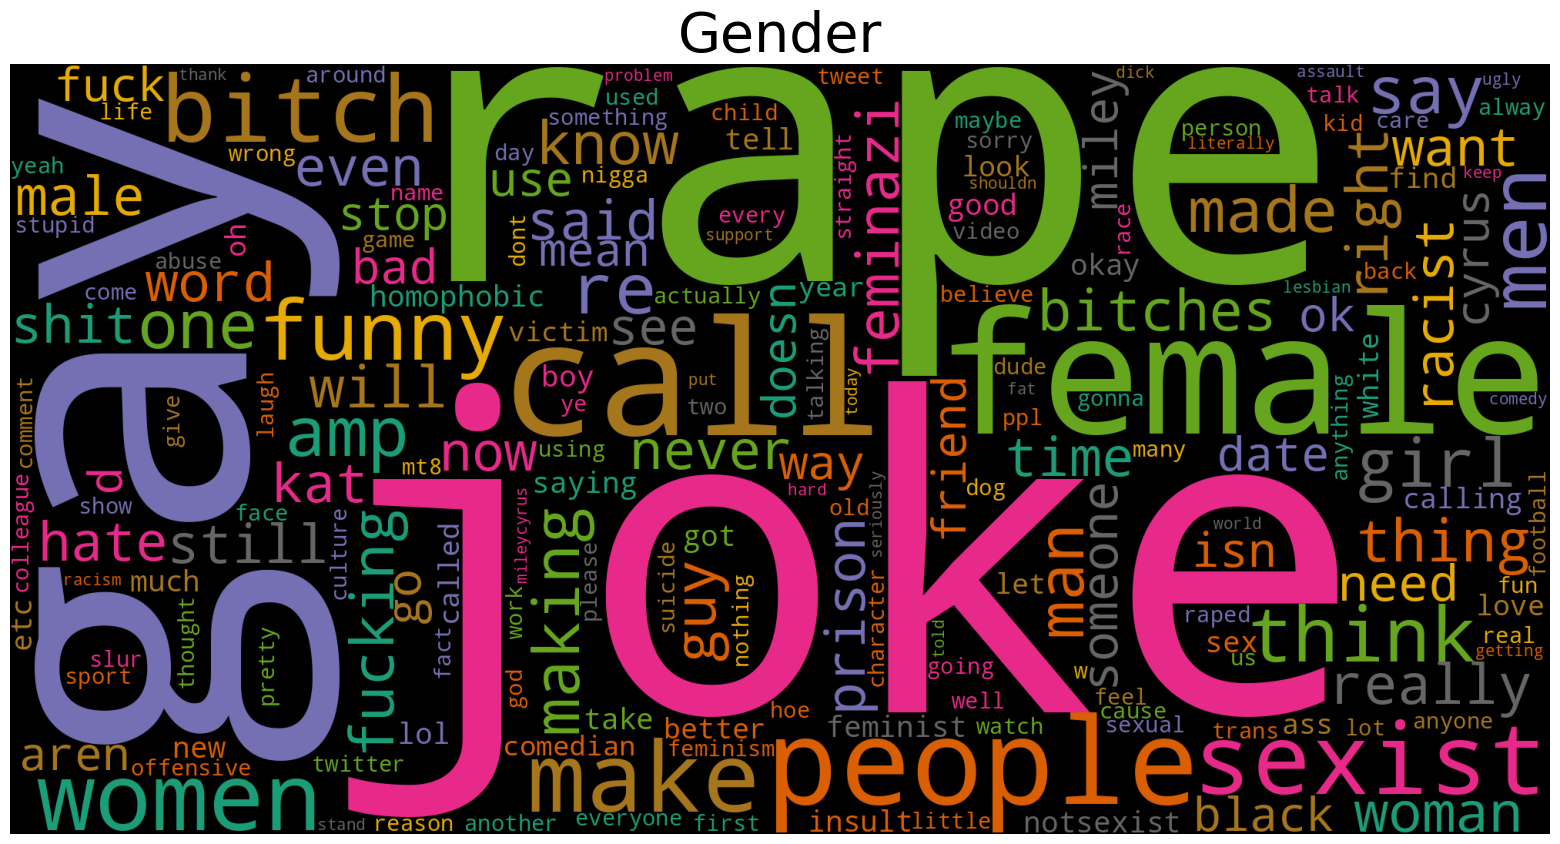

In [18]:
plt.figure(figsize=(20,10))
subset1 = df_visual[df_visual['bully_type'] == 'gender']
text_gender = subset1.text.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_gender))

plt.axis('off')
plt.title("Gender",fontsize=40)
plt.imshow(cloud1)


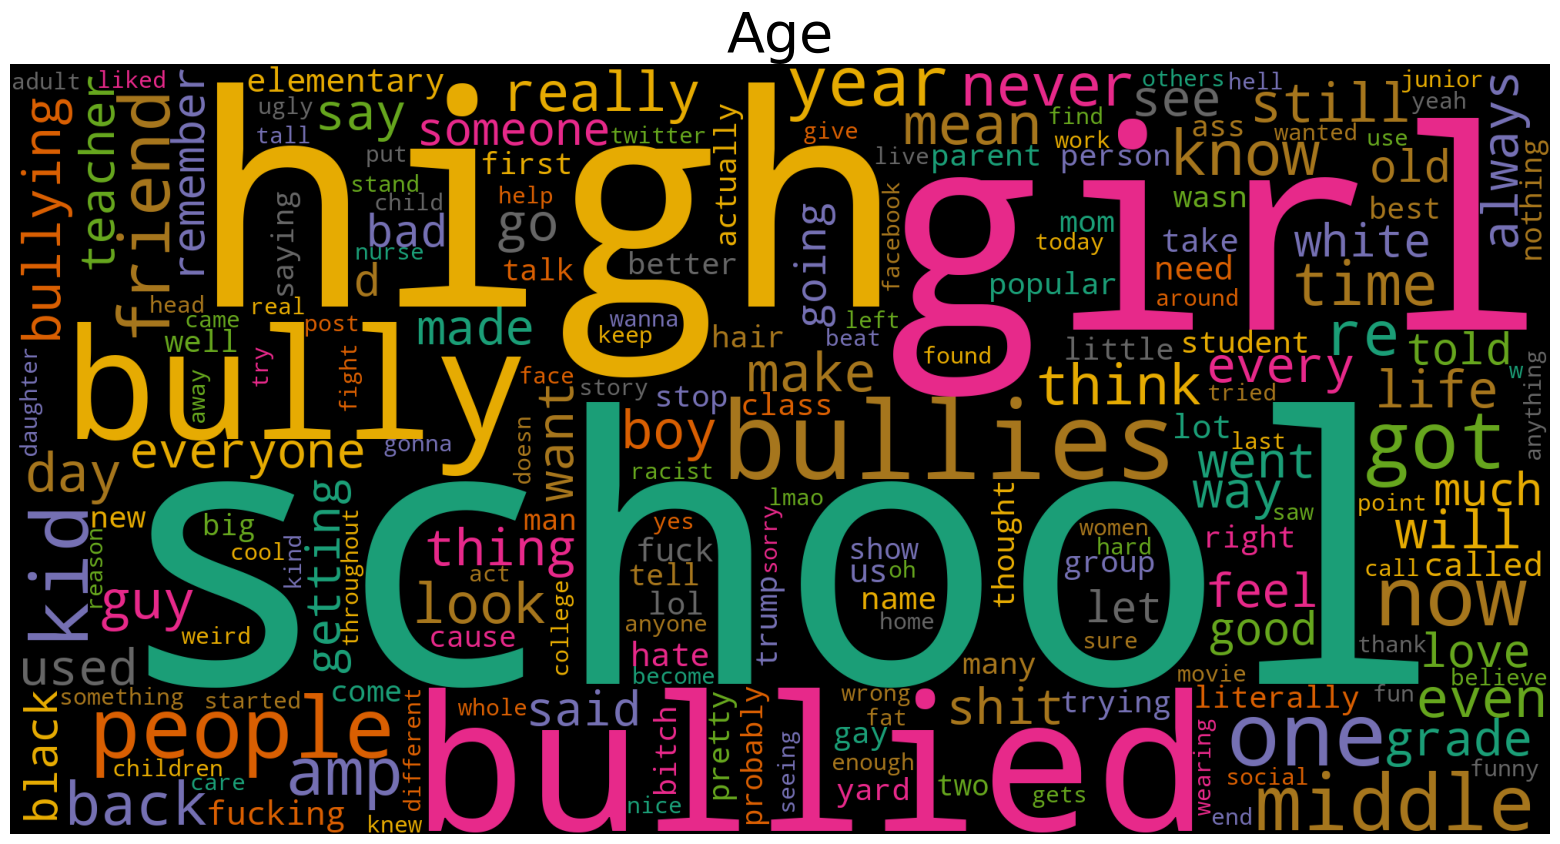

In [19]:
plt.figure(figsize=(20,10)) #Setting figure size to better width

subset_age = df_visual[df_visual['bully_type']=='age']
text_age = subset_age.text.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_age))

plt.axis('off')
plt.title("Age",fontsize=40)
plt.imshow(cloud1)

In [20]:
import re, string
import demoji
import emoji #!pip install emoji
import nltk #!pip install nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

# Remove all emojis from text, since it is a twitter it might include some amount of emojis
def remove_emojis(text):
    return demoji.replace(text, '') #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
   # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = remove_emojis(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text
new_texts = []
for each_text in df['text']:
    new_texts.append(deep_clean(each_text))

In [22]:
df['new_tweet'] = new_texts

In [23]:
df.head()

,text,bully_type,new_tweet
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying,eek stand split keyboard work well mmo
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying,rather funni us complet differ yet complement skill set well
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying,old oil clich us pay everi drop oil get open market like everi countri
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc


In [24]:
print(f'Shape: {df.shape}')
sum_duplicate = df["new_tweet"].duplicated().sum()
print(f'Duplicated Sum: {sum_duplicate}')

Shape: (47647, 3)
Duplicated Sum: 2962


In [25]:
df.drop_duplicates("new_tweet", inplace=True)

In [26]:
df.shape

(44685, 3)

In [27]:
df['bully_type'].value_counts()

bully_type
religion               7953
age                    7882
ethnicity              7779
not_cyberbullying      7659
gender                 7618
other_cyberbullying    5794
Name: count, dtype: int64

In [28]:
df = df[df["bully_type"]!="other_cyberbullying"]

In [29]:
text_length = []
for each_text in df['new_tweet']:
    each_length = len(each_text.split())
    text_length.append(each_length)

In [30]:
# Apply the text length list array into data frame
df['text_length'] = text_length
df.head()

<ipython-input-30-a0ca5ec0cd57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = text_length


,text,bully_type,new_tweet,text_length
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,5
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying,eek stand split keyboard work well mmo,7
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying,rather funni us complet differ yet complement skill set well,10
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying,old oil clich us pay everi drop oil get open market like everi countri,14
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc,11


<ipython-input-31-aab128849ecf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_length', data=df[df['text_length']<10], palette='mako')


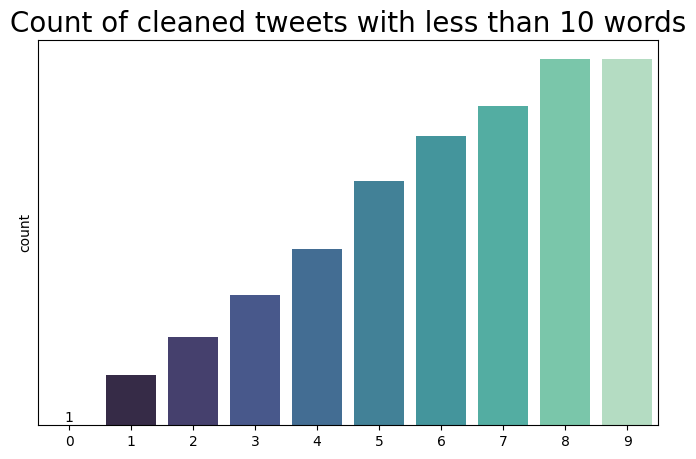

In [31]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='text_length', data=df[df['text_length']<10], palette='mako')
plt.title('Count of cleaned tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [32]:
df = df[df['text_length'] > 3]

In [33]:
pd.set_option('display.max_colwidth', 100)
df.sort_values(by=['text_length'], ascending=False)

,text,bully_type,new_tweet,text_length
44036,You so black and white trying to live like a nigger... Pahahahaha... Common is dumb as fuck!\nit...,ethnicity,black white tri live like nigger pahahahaha common dumb fuck short huntsman dumb ass ya fuck gay...,188
45166,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass nigger” this bitch &lt;~~This Whore SMH\nI don’t t...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore smh dont think either dont put anyth past nigga com...,164
33725,"... I don't feel guilty for killing him, I just feel guilty because I enjoyed it. He tormented s...",age,feel guilti kill feel guilti enjoy torment sinc child even let bulli school harass almost cut ey...,140
1318,@EurekAlertAAAS: Researchers push to import top anti-bullying program to US schools http://t.co/...,not_cyberbullying,research push import top antibulli program us school instead person attack mayb explain 100 isla...,139
47038,@Purely_Ambition: Sooo mad. RT @TracePeterson Fuck Obama that dumb nigger I'm going to Switzerla...,ethnicity,sooo mad rt fuck obama dumb nigger go switzerlan yooomaddddddd lmfaoo shut fuck dumb nigger sout...,126
...,...,...,...,...
36272,taemin’s bullies in middle school @taemin,age,taemin bulli middl school,4
18172,@depressedfuck1 @CompoundMixture @CruisingBye @SuperiorMenArmy In know more about the religion t...,religion,know religion pure evil,4
117,Lolol that boy is whipped AF,not_cyberbullying,lolol boy whip af,4
6906,@TURBOCUNT huh. i might have to try this at some point.,not_cyberbullying,huh might tri point,4


<ipython-input-34-c814b05d96ac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_length', data=df[(df['text_length']<=1000) & (df['text_length']>10)], palette='Blues_r')


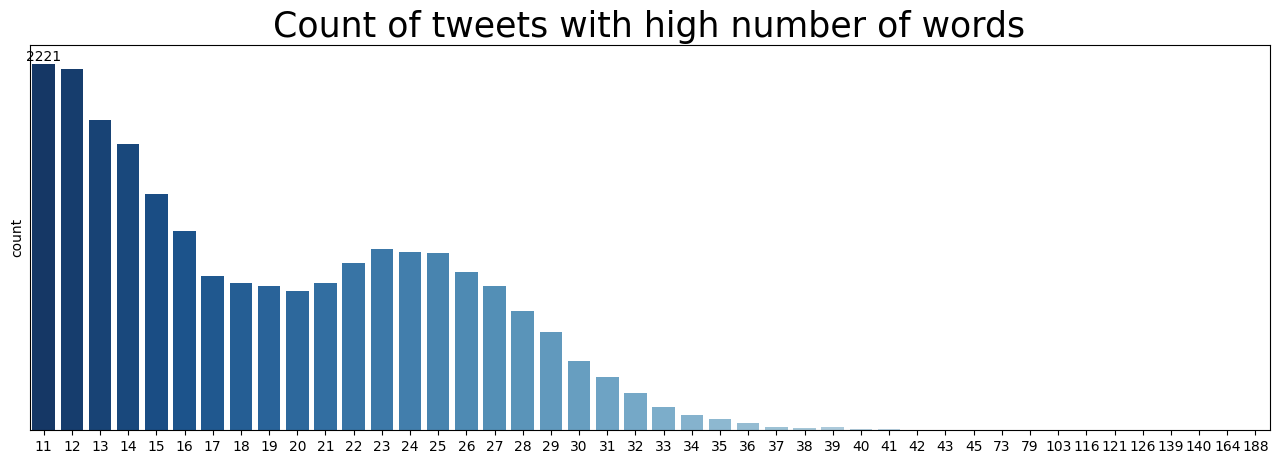

In [34]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_length', data=df[(df['text_length']<=1000) & (df['text_length']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [35]:
X = df['new_tweet']
y = df['bully_type']

In [36]:
from sklearn.model_selection import train_test_split

seed_value = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed_value)

In [37]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (31627,)
y_train: (31627,)
X_test: (5582,)
y_test: (5582,)


In [38]:
max_features = 10000
maxlen = 300

In [39]:
from keras.preprocessing import text,sequence

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)
X_test

array([[   0,    0,    0, ...,   13,   66,   42],
       [   0,    0,    0, ...,  673,  468,    1],
       [   0,    0,    0, ...,  842,  401, 4544],
       ...,
       [   0,    0,    0, ..., 2631,   24,   57],
       [   0,    0,    0, ...,   68, 1333,    1],
       [   0,    0,    0, ..., 2794,   18, 6660]], dtype=int32)

In [40]:
X_train

array([[   0,    0,    0, ..., 2316,   42,  236],
       [   0,    0,    0, ...,  148,  713,   95],
       [   0,    0,    0, ...,  531,   49, 1471],
       ...,
       [   0,    0,    0, ...,    2,  283,  691],
       [   0,    0,    0, ...,    1,   51,  940],
       [   0,    0,    0, ...,   87,   79,  280]], dtype=int32)

In [41]:
y_test

11502               gender
239      not_cyberbullying
10203               gender
17821             religion
47063            ethnicity
               ...        
44474            ethnicity
12962               gender
22838             religion
31948                  age
4160     not_cyberbullying
Name: bully_type, Length: 5582, dtype: object

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Embedding
batch_size = 256
epochs = 2
embed_size = 100

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout
model5 = Sequential()

#Non-trainable embeddidng layer
model5.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))

#BLSTM
model5.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(5, 10)))
model5.add(Bidirectional(LSTM(10)))

#Hidden Layer
model5.add(Dense(256, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.3))

model5.add(Dense(6, activation='softmax'))

In [44]:
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                11120     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8

In [45]:
y_train = y_train.replace('religion', 1)
y_train = y_train.replace('gender', 1)
y_train = y_train.replace('age', 1)
y_train = y_train.replace('ethnicity', 1)
y_train = y_train.replace('not_cyberbullying', 0)
y_train = y_train.astype('int64')
epochs5 = 40
history5 = model5.fit(X_train, y_train.astype('int64'), validation_split=0.1, epochs=epochs5, batch_size=128)

Epoch 1/40
223/223 [==============================] - 24s 56ms/step - loss: 0.5622 - accuracy: 0.8149 - val_loss: 0.3200 - val_accuracy: 0.8533
Epoch 2/40
223/223 [==============================] - 10s 44ms/step - loss: 0.3129 - accuracy: 0.8553 - val_loss: 0.2659 - val_accuracy: 0.8799
Epoch 3/40
223/223 [==============================] - 11s 47ms/step - loss: 0.2833 - accuracy: 0.8716 - val_loss: 0.2642 - val_accuracy: 0.8833
Epoch 4/40
223/223 [==============================] - 11s 49ms/step - loss: 0.2766 - accuracy: 0.8765 - val_loss: 0.2724 - val_accuracy: 0.8758
Epoch 5/40
223/223 [==============================] - 11s 50ms/step - loss: 0.2684 - accuracy: 0.8813 - val_loss: 0.2495 - val_accuracy: 0.8919
Epoch 6/40
223/223 [==============================] - 10s 43ms/step - loss: 0.2622 - accuracy: 0.8835 - val_loss: 0.2458 - val_accuracy: 0.8941
Epoch 7/40
223/223 [==============================] - 12s 52ms/step - loss: 0.2550 - accuracy: 0.8863 - val_loss: 0.2405 - val_accuracy:

In [46]:
print("Accuracy of the model on Training Data is - " , model5.evaluate(X_train,y_train)[1]*100 , "%")
y_test = y_test.replace('not_cyberbullying', 0)
y_test = y_test.replace('religion', 1)
y_test = y_test.replace('gender', 1)
y_test = y_test.replace('age', 1)
y_test = y_test.replace('ethnicity', 1)
y_test = y_test.astype('float32')


print("Accuracy of the model on Testing Data is - " , model5.evaluate(X_test,y_test)[1]*100 , "%")

989/989 [==============================] - 19s 20ms/step - loss: 0.1394 - accuracy: 0.9411
Accuracy of the model on Training Data is -  94.11262273788452 %
175/175 [==============================] - 6s 23ms/step - loss: 0.2099 - accuracy: 0.9196
Accuracy of the model on Testing Data is -  91.95628762245178 %


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot

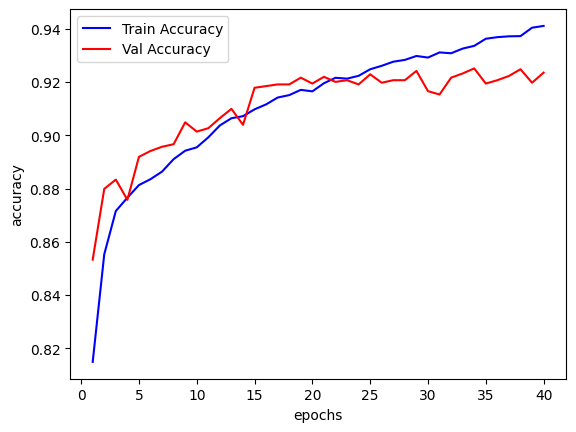

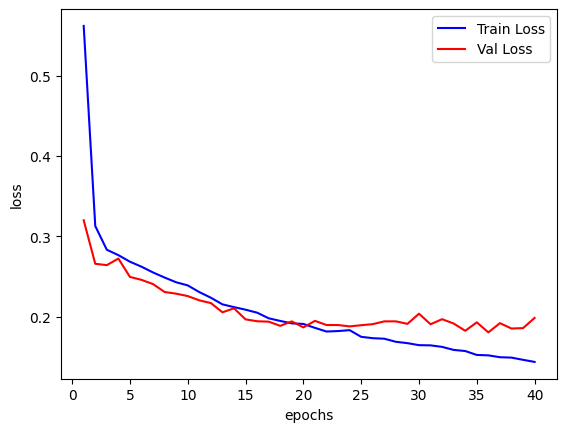

In [48]:
import matplotlib.pyplot as plt

acc5 = history5.history['accuracy']
val_acc5 = history5.history['val_accuracy']
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

epochs = range(1, len(acc5)+1)

plt.plot(epochs, acc5, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc5, 'r', label='Val Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss5, 'b', label='Train Loss')
plt.plot(epochs, val_loss5, 'r', label='Val Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

predict_x5 = model5.predict(X_test)
y_pred5 = np.argmax(predict_x5,axis=1)

cf5 = confusion_matrix(y_test, y_pred5)
cf5

175/175 [==============================] - 4s 18ms/step


array([[ 746,  214],
       [ 235, 4387]])

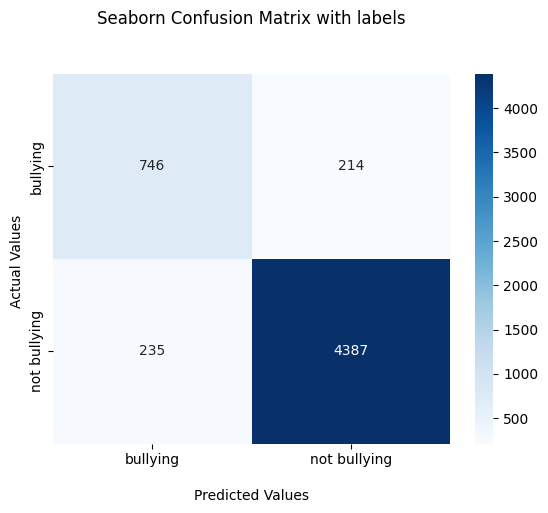

In [50]:
import seaborn as sns
x_axis_labels = ['bullying', 'not bullying']
y_axis_labels = ['bullying', 'not bullying']
ax = sns.heatmap(cf5, annot=True, cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred5, target_names = ['not bullying','bullying']))

              precision    recall  f1-score   support

not bullying       0.76      0.78      0.77       960
    bullying       0.95      0.95      0.95      4622

    accuracy                           0.92      5582
   macro avg       0.86      0.86      0.86      5582
weighted avg       0.92      0.92      0.92      5582



In [77]:
import numpy as np
from keras.preprocessing import text, sequence

# Function to preprocess the input text
def preprocess_text(input_text):
    input_text = lower(input_text)
    input_text = clean_tweet_re(input_text)
    input_text = remove_stopwords(input_text)
    input_text = remove_emojis(input_text)
    input_text = decontract(input_text)
    input_text = strip_all_entities(input_text)
    input_text = clean_hashtags(input_text)
    input_text = filter_chars(input_text)
    input_text = remove_mult_spaces(input_text)
    input_text = stemmer(input_text)
    return input_text

# Function to tokenize and pad the input text
def tokenize_and_pad(input_text):
    max_features = 10000
    maxlen = 300
    tokenizer = text.Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts([input_text])
    tokenized_text = tokenizer.texts_to_sequences([input_text])
    padded_text = sequence.pad_sequences(tokenized_text, maxlen=maxlen)
    return padded_text

# Function to predict the class of the input text
def predict_class(input_text, model):
    preprocessed_text = preprocess_text(input_text)
    padded_text = tokenize_and_pad(preprocessed_text)
    prediction = model.predict(padded_text)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class

# Mapping predicted class to label
def map_class_to_label(predicted_class):
    label_map = {0: 'not_cyberbullying', 1: 'cyberbullying'}
    return label_map.get(predicted_class[0])

# Function to take an input text and print its prediction
def test_prediction(input_text):
    predicted_class = predict_class(input_text, model5)
    label = map_class_to_label(predicted_class)
    print(f"Input Text: {input_text}")
    print(f"Predicted Class: {label}")

# Example usage
test_input_text = " karma hope bites kat butt nasty  "
test_prediction(test_input_text)
test_input_text2 = "@Slim_chaney I LOVE YOU"
test_prediction(test_input_text2)


1/1 [==============================] - 0s 32ms/step
Input Text:  karma hope bites kat butt nasty  
Predicted Class: cyberbullying
1/1 [==============================] - 0s 31ms/step
Input Text: @Slim_chaney I LOVE YOU
Predicted Class: not_cyberbullying
